In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import csv
import function as func

# Setting

In [2]:
outdir = './output/check_15.7GHz'

import os
if not os.path.isdir(outdir):
    os.mkdir(outdir)
    pass

In [35]:
datadir = '/data/ms2840a/2023-06-27/data'
filenames = [
    #'300K_RBW2MHz_SWEEP.dat',
    #'300KinLN2box_RBW2MHz_SWEEP.dat',
    '300KinLN2box_RBW2MHz_SWEEP1000.dat',
    #'77K_RBW2MHz_SWEEP.dat',
    '77K_RBW2MHz_SWEEP1000.dat',
    #'Al_RBW2MHz_SWEEP1000.dat',
    #'AlFloat2cm_RBW2MHz_SWEEP1000.dat',
    #'77KFloat2cm_RBW2MHz_SWEEP1000.dat',
    '77K_NoIsolator_RBW2MHz_SWEEP1000.dat',
    #'77K_NewCable_RBW2MHz_SWEEP1000.dat',
    #'77K_NewCable_RBW2MHz_SWEEP300_2.dat',
]
labels = [
    #'300K',
    #'300K in LN2 box',
    '300K in LN2 box',
    #'77K',
    '77K',
    #'Al',
    #'Al floating 2cm',
    #'77K floating 2cm',
    '77K No Isolator',
    #'77K New cable',
    #'77K New cable 2',
]
#freq_min = 15.0 # [GHz]
#freq_max = 16.0 # [GHz]
freq_min = 0.0 # [GHz]
freq_max = 20.0 # [GHz]
legendON = True
csvType = 'TwoColumn'; # freq, dBm

# default average binning
nFreqAve = 50

# constant
k_B = func.k_B  # boltzmann const. [J/K]

In [36]:
print(filenames)
print(labels)

['300KinLN2box_RBW2MHz_SWEEP1000.dat', '77K_RBW2MHz_SWEEP1000.dat', '77K_NoIsolator_RBW2MHz_SWEEP1000.dat']
['300K in LN2 box', '77K', '77K No Isolator']


# Define function to read csv datafile

In [37]:
# start_freq, stop_freq, npoints are only used in OneColumn type
def read_csv(filename, csvType='Anritsu', start_freq=None, stop_freq=None, npoints=None):
    
    freq = [] # frequency list [GHz]
    power = [] # power list  [mW]
    
    f = open(filename, 'r');
    if csvType=='TwoColumn':
        fin = list( csv.reader(f, delimiter=' ') )
    else:
        fin = list(csv.reader(f))
    #print(fin)  #リストの中身を出力
    isData = False
    
    if csvType=='Anritsu': # Anritsu : NOTE: only for RMS detection
        
        start_freq = 0
        stop_freq = 0
        npoints = 0
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            # Search for frequency range
            if first == 'Trace-A':
                start_freq = int(line[1])
                stop_freq  = int(line[2])
                continue
            # Search for npoints
            if first == 'RMS':
                npoints = int(line[1])
                continue
            # Search for data starting point (Anritsu: Wave Data)
            if first.startswith('Wave Data'):
                isData = True
                continue
            # Get data
            if isData:
                power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
                pass
            pass
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
            
    elif csvType=='Keysight' : # Keysight
        
        for line in fin:
            if len(line)==0 : continue
            # Search for data starting point (Keysight: DATA)
            #print(f'first = {first}')
            if first == 'DATA':
                isData = True
                continue
            isData = True # All lines are data
            # Get data
            if isData:
                freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
                power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
                pass
            pass
        
    elif csvType=='TwoColumn' : # Hz, dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
            power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
            pass
        
    elif csvType=='OneColumn' : # dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
            pass
        if (start_freq is None) or (stop_freq is None) or (npoints is None):
            print('Error! There is no arguments for frequency information (start_freq, stop_freq, npoints).')
            print('Error! Please specify them!')
            return None
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
        
        pass
    
    return np.array(freq), np.array(power)
                

# Define funcition to calculate frequency average

In [38]:
def freq_average(data, naverage=100):

    ndata = len(data)
    npoints = int(ndata/naverage)
    
    data_ave = []
    data_err = []
    
    for i in range(npoints):
        data_subset = data[i*naverage:(i+1)*naverage]
        average = np.mean(data_subset)
        average_err = np.std(data_subset)/np.sqrt(naverage) #  = 1/N * sqrt( sum((y-mean)^2))  ( std = sqrt( sum((y-mean)^2) / N) )
        data_ave.append(average)
        data_err.append(average_err)
        pass
    
    return np.array(data_ave), np.array(data_err)

# Define function to interpolate spectrum over frequency

In [39]:
# interp_kind = 'linear': linear interpolation
# interp_kind = 'cubic' : splineinterpolation
from scipy import interpolate
def freq_interpolate(freq, freq1, power1, interp_kind='cubic'):
    interp_func = interpolate.interp1d(freq1, power1, kind=interp_kind)
    return interp_func(freq)

# Read csv data

In [40]:
freqs_array = []
powers_array = []
for filename in filenames:
    _freq, _power = read_csv(f'{datadir}/{filename}', csvType)
    
    # Select data between freq_min and freq_max
    _power = _power[_freq<=freq_max]
    _freq = _freq[_freq<=freq_max]
    _power = _power[_freq>=freq_min]
    _freq = _freq[_freq>=freq_min]
    
    freqs_array.append(_freq)
    powers_array.append(_power)
    pass

freqs_array = np.array(freqs_array)
powers_array = np.array(powers_array)

In [41]:
print(freqs_array)
print(powers_array)
print(freqs_array)
print(powers_array)

[[0.0000e+00 2.0000e-03 4.0000e-03 ... 1.9996e+01 1.9998e+01 2.0000e+01]
 [0.0000e+00 2.0000e-03 4.0000e-03 ... 1.9996e+01 1.9998e+01 2.0000e+01]
 [0.0000e+00 2.0000e-03 4.0000e-03 ... 1.9996e+01 1.9998e+01 2.0000e+01]]
[[1.78361062e-04 1.36647056e-07 1.30196819e-08 ... 2.13304536e-07
  2.14437312e-07 2.18776239e-07]
 [1.67032147e-04 1.24394106e-07 1.29479247e-08 ... 2.08737229e-07
  2.07730519e-07 2.05399766e-07]
 [1.62293103e-04 1.18604108e-07 1.28114899e-08 ... 2.83204645e-07
  2.80220464e-07 2.74662930e-07]]
[[0.0000e+00 2.0000e-03 4.0000e-03 ... 1.9996e+01 1.9998e+01 2.0000e+01]
 [0.0000e+00 2.0000e-03 4.0000e-03 ... 1.9996e+01 1.9998e+01 2.0000e+01]
 [0.0000e+00 2.0000e-03 4.0000e-03 ... 1.9996e+01 1.9998e+01 2.0000e+01]]
[[1.78361062e-04 1.36647056e-07 1.30196819e-08 ... 2.13304536e-07
  2.14437312e-07 2.18776239e-07]
 [1.67032147e-04 1.24394106e-07 1.29479247e-08 ... 2.08737229e-07
  2.07730519e-07 2.05399766e-07]
 [1.62293103e-04 1.18604108e-07 1.28114899e-08 ... 2.83204645e-0

###  Plot Power [mW]

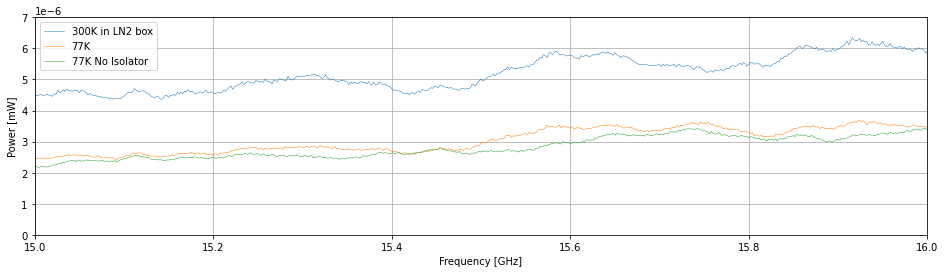

In [42]:
fig = plt.figure(figsize=(16,4))
for i, filename in enumerate(filenames):
    plt.plot(freqs_array[i], powers_array[i], label=f'{labels[i]}', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    pass
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
plt.xlim(15,16) #x軸範囲指定
plt.ylim(0,0.7e-5) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定
plt.grid(True)

if legendON: plt.legend()

#plt.savefig(f'{outdir}/compare_multiple_power_mW.png')
plt.show()

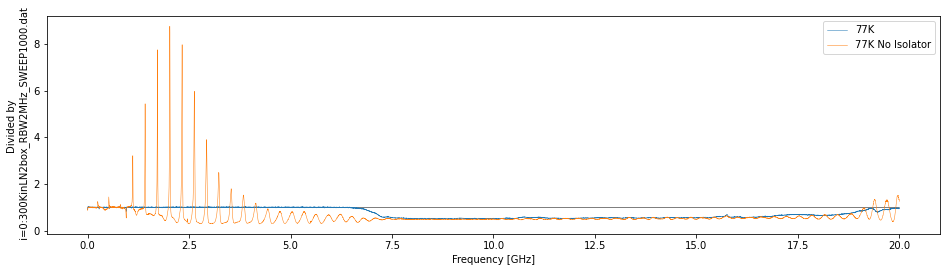

In [43]:
freq0 = freqs_array[0]
power0 = powers_array[0]
fig = plt.figure(figsize=(16,4))
plt.plot(freq0, np.full(len(freq0), 1.), color='k', linewidth=0.5, linestyle='-')
for i, filename in enumerate(filenames):
    if i==0: continue
    power_interp = freq_interpolate(freq0, freqs_array[i], powers_array[i])
    div_power =power_interp/power0
    plt.plot(freq0, div_power, label=f'{labels[i]}', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'Divided by \n i=0:{filenames[0]}') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

if legendON: plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power_div.png')
plt.show()

##  Plot Power [dBm]

###  Plot Power [dBm] in the same figure

power > -65 dB: 0 @ [0.] GHz
power > -65 dB: 1 @ [0.] GHz
power > -65 dB: 2 @ [0.] GHz


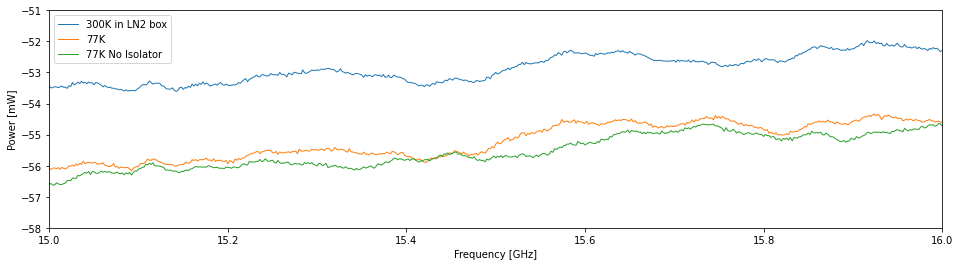

In [53]:
fig = plt.figure(figsize=(16,4))
for i, filename in enumerate(filenames):
    power_dBm = np.log10(powers_array[i])*10.
    plt.plot(freqs_array[i], power_dBm, label=f'{labels[i]}', marker='', markersize=0.5, linestyle='-', linewidth=1)
    #cutdBm = -60
    cutdBm = -65
    if max(power_dBm)>cutdBm: 
        print(f'power > {cutdBm} dB: {i} @ {freqs_array[i][power_dBm==np.max(power_dBm)]} GHz')
        pass
    pass
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
plt.xlim(15,16) #x軸範囲指定
plt.ylim(-58,-51) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

if legendON: plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power_dBm.png')
plt.show()

power > -65 dB: 0 @ [0.] GHz
power > -65 dB: 1 @ [0.] GHz
power > -65 dB: 2 @ [0.] GHz


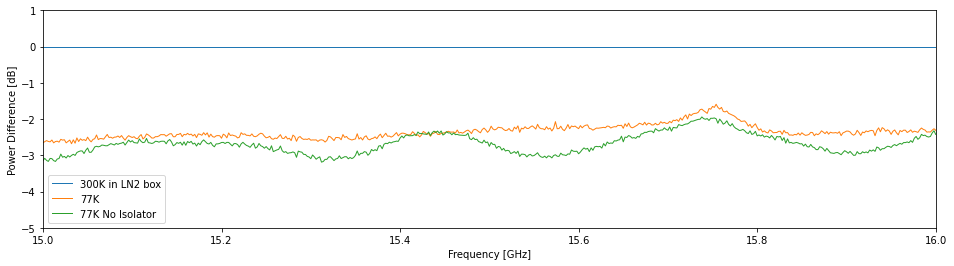

In [54]:
fig = plt.figure(figsize=(16,4))
for i, filename in enumerate(filenames):
    power_dBm_diff = np.log10(powers_array[i])*10. - np.log10(powers_array[0])*10.
    plt.plot(freqs_array[i], power_dBm_diff, label=f'{labels[i]}', marker='', markersize=0.5, linestyle='-', linewidth=1)
    #cutdBm = -60
    cutdBm = -65
    if max(power_dBm)>cutdBm: 
        print(f'power > {cutdBm} dB: {i} @ {freqs_array[i][power_dBm==np.max(power_dBm)]} GHz')
        pass
    pass
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power Difference [dB]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
plt.xlim(15, 16) #x軸範囲指定
plt.ylim(-5,1) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

if legendON: plt.legend()

###  Plot Power [dBm] in each panel

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


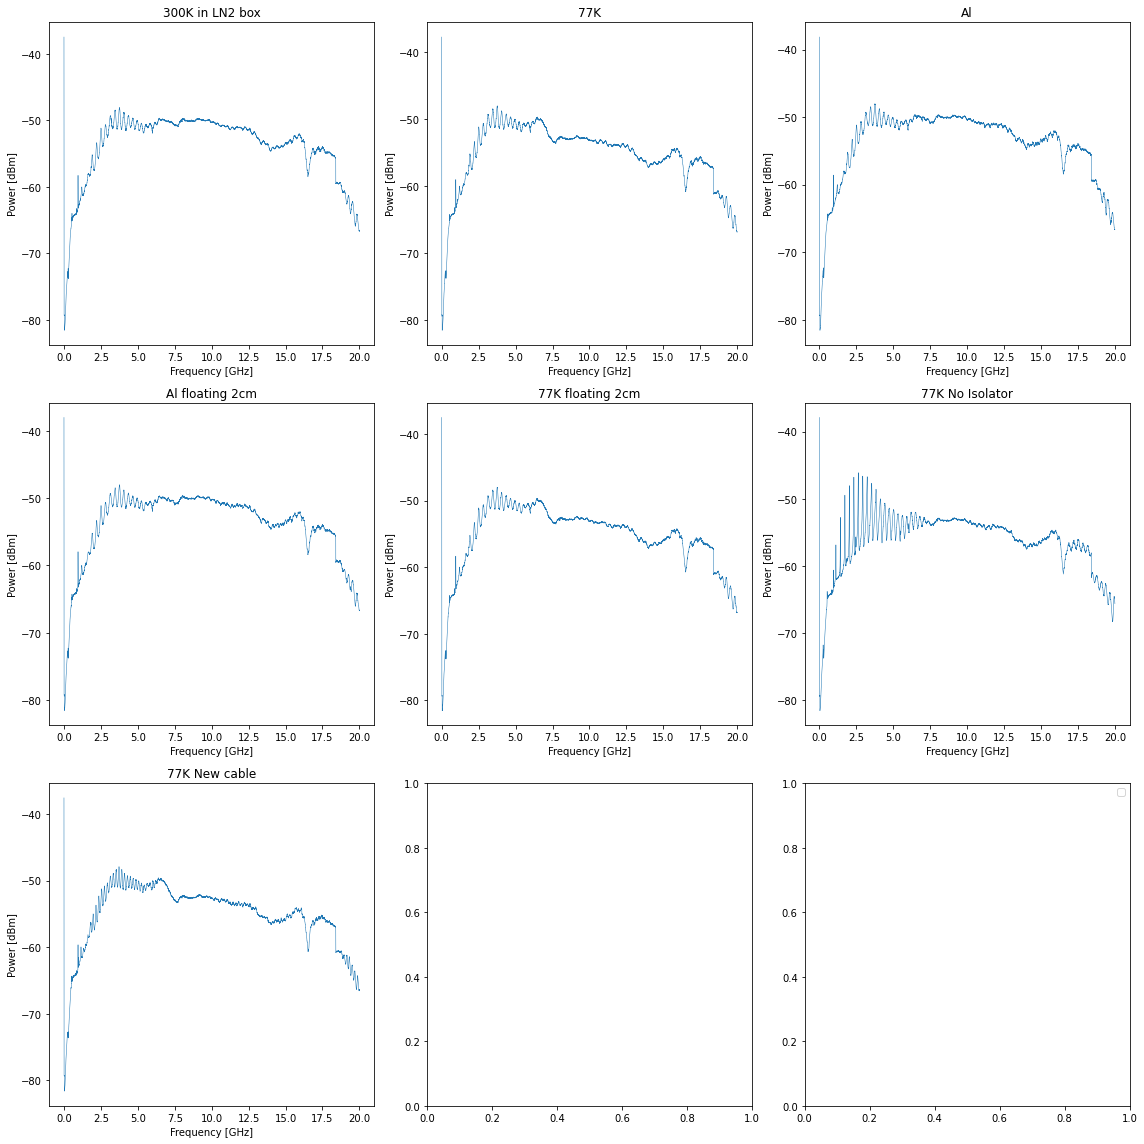

In [14]:
fig, axes = plt.subplots((int)(len(filenames)/3)+1, 3, figsize=(16,16), sharex=False, squeeze=False)
for n, filename in enumerate(filenames):
    i = (int)(n/3)
    j = n%3
    ax = axes[i][j]
    ax.set_title(labels[n])
    power_dBm = np.log10(powers_array[n])*10.
    ax.plot(freqs_array[n], power_dBm, label=f'{labels[n]}', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    ax.set_xlabel('Frequency [GHz]') #x軸の名前
    ax.set_ylabel('Power [dBm]') #y軸の名前
    pass

if legendON: plt.legend()

plt.tight_layout()
plt.savefig(f'{outdir}/compare_multiple_power_dBm_eachpanel.pdf')
plt.show()

### Plot averaged power

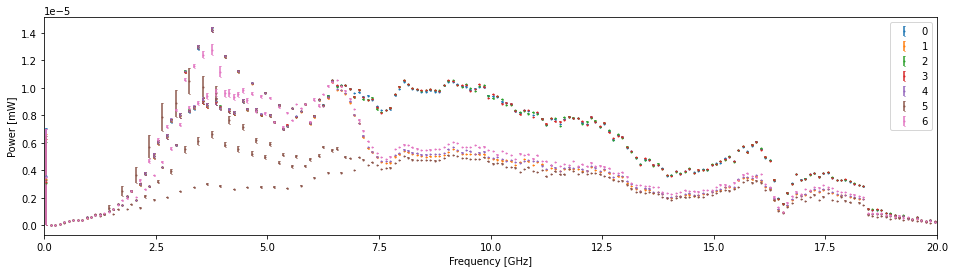

In [15]:
## Averaging
freqs_ave_array = []
powers_ave_array = []
powers_ave_err_array = []
for i, filename in enumerate(filenames):
    _freq_ave, tmp = freq_average(freqs_array[i], naverage=nFreqAve)
    _power_ave, _power_ave_err = freq_average(powers_array[i], naverage=nFreqAve)
    freqs_ave_array.append(_freq_ave)
    powers_ave_array.append(_power_ave)
    powers_ave_err_array.append(_power_ave_err)
    pass
freqs_ave_array = np.array( freqs_ave_array )
powers_ave_array = np.array( powers_ave_array )
powers_ave_err_array = np.array( powers_ave_err_array )

## Plotting
fig = plt.figure(figsize=(16,4))
for i, filename in enumerate(filenames):
    plt.errorbar(freqs_ave_array[i], powers_ave_array[i], yerr=powers_ave_err_array[i], 
                 label=f'{i}', capsize=0.5, fmt='o', markersize=1, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                )
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(0,0.006) #y軸範囲指定
if legendON: plt.legend()

plt.savefig(f"{outdir}/compare_multiple_power_average.png")
plt.show()

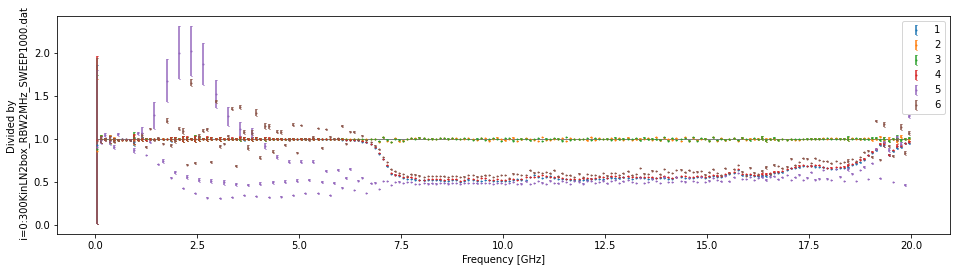

In [16]:
freq0 = freqs_ave_array[0]
power0 = powers_ave_array[0]
fig = plt.figure(figsize=(16,4))
plt.plot(freq0, np.full(len(freq0), 1.), color='k', linewidth=0.5, linestyle='-')
for i, filename in enumerate(filenames):
    if i==0: continue
    power_interp = freq_interpolate(freq0, freqs_ave_array[i], powers_ave_array[i])
    power_err_interp = freq_interpolate(freq0, freqs_ave_array[i], powers_ave_err_array[i])
    div_power = power_interp/power0
    div_power_err = power_err_interp/power0
    plt.errorbar(freq0, div_power, yerr=div_power_err, 
                 label=f'{i}', capsize=0.5, fmt='o', markersize=1, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                )
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'Divided by \n i=0:{filenames[0]}') #y軸の名前
if legendON: plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power-ave_div.png')
plt.show()